In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/labels-in-the-wild/images/im23_edit5.jpg
/kaggle/input/labels-in-the-wild/images/im36_edit3.jpg
/kaggle/input/labels-in-the-wild/images/im21_edit1.jpg
/kaggle/input/labels-in-the-wild/images/im13_edit1.jpg
/kaggle/input/labels-in-the-wild/images/5482.jpg
/kaggle/input/labels-in-the-wild/images/im9_edit2.jpg
/kaggle/input/labels-in-the-wild/images/im31_edit3.jpg
/kaggle/input/labels-in-the-wild/images/im9_edit4.jpg
/kaggle/input/labels-in-the-wild/images/2844.jpg
/kaggle/input/labels-in-the-wild/images/5789.jpg
/kaggle/input/labels-in-the-wild/images/5266.jpg
/kaggle/input/labels-in-the-wild/images/im41_edit2.jpg
/kaggle/input/labels-in-the-wild/images/im27_edit2.jpg
/kaggle/input/labels-in-the-wild/images/im4_edit1.jpg
/kaggle/input/labels-in-the-wild/images/im35_edit4.jpg
/kaggle/input/labels-in-the-wild/images/5483.jpg
/kaggle/input/labels-in-the-wild/images/im37_edit1.jpg
/kaggle/input/labels-in-the-wild/images/im32_edit4.jpg
/kaggle/input/labels-in-the-wild/images/im2

## Importing the libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from pathlib import Path
import scipy
from sklearn.cluster import SpectralClustering
from skimage import io, transform
from PIL import Image
import cv2
import copy,os,sys
import random
import math
import pickle
import string

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Normalizes x using mean and std
# dimension of x= (w,h,c)
def normalize(x,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]):
    mean=torch.tensor(mean)
    std=torch.tensor(std)
    return (x-mean)/std

def denormalize(x,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]):
    mean=torch.tensor(mean)
    std=torch.tensor(std)
    return x*std+mean

# changes dim of x from (w,h,3)->(1,3,w,h) to easily pass through model
def img2passable(x):
    x=x.permute((2,0,1))
    x=x.unsqueeze(0)
    return x

# inverse of img_to_passable
# converts (1,3,w,h) to (w,h,3)
def passable2img(x):
    x=x.squeeze(0)
    x=x.permute((1,2,0))
    return x

## Neural Network Classes - Resnet, Siamese & Consistency models

In [4]:
class Resnet_backbone(nn.Module):
    def __init__(self):
        super(Resnet_backbone,self).__init__()
        resnet50=torchvision.models.resnet50(pretrained=True)
        
        # Freeze all the layers
        for param in resnet50.parameters():
            param.requires_grad = False

        # Get feature vector from last layer 
        self.get_feature=nn.Sequential(*list(resnet50.children())[:-1])

    def forward(self,x):
        x=self.get_feature(x)
        return x

class Siamese(nn.Module):
    def __init__(self):
        super(Siamese,self).__init__()
        self.resnet=Resnet_backbone()
        self.exif_features=nn.Sequential(
                            nn.Linear(4096,2048),
                            nn.ReLU(),
                            nn.Linear(2048,1024),
                            nn.ReLU(),
                            nn.Linear(1024,163))  

    def forward(self,x,y):
        x=self.resnet(x).view(-1,2048)
        y=self.resnet(y).view(-1,2048)
        out=torch.cat((x,y),axis=1)   # To combine feature vectors of both image
        out=self.exif_features(out)
        return out

# To get consistency of the two patches
class Consistency(nn.Module):
    # siamese is pretrained siamese network to get exif features
    def __init__(self,siamese):
        super(Consistency,self).__init__()
        self.siamese=siamese

        # # Freeze all the layers
        # for param in self.siamese.parameters():
        #     param.requires_grad = False

        self.get_consistency=nn.Sequential(
                                nn.ReLU(),
                                nn.Linear(163,512),  
                                nn.ReLU(),
                                nn.Linear(512,2))

    def forward(self,x,y):
        x=self.siamese(x,y)
        out=self.get_consistency(x)
        return out

## First Loading the EXIF model and then the Consistency model


In [5]:
exif_model=Siamese().to(device)
saved_model_path = '../input/self-consistency-models/Exif_model.pth'

if device==torch.device('cuda'):
    checkpoint = torch.load(saved_model_path)
else:
    checkpoint = torch.load(saved_model_path, map_location=torch.device('cpu'))

exif_model.load_state_dict(checkpoint['model_state_dict'])

model = Consistency(exif_model).to(device)

saved_model_path = '../input/self-consistency-models/Consistent_model.pth'
if device==torch.device('cuda'):
    checkpoint = torch.load(saved_model_path)
else:
    checkpoint = torch.load(saved_model_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

<All keys matched successfully>

## Input Image Preprocessing

In [6]:
test_transform=transforms.Compose([transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])               # normalize by ImageNet statistics

# Load the image given image path
# output- tensor of size (1,c,w,h)
def load_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if np.max(img)>1:
        img = img/255
    img = test_transform(img)
    return img.float().unsqueeze(0)
    

# Gets the height and width of the image after stride 
def get_stride_new_dim(img, stride):
    stride_h, stride_w = stride
    h, w = img.size()[2:]
    h_new = (h-128)//stride_h + 1 
    w_new = (w-128)//stride_w + 1 
    return h_new, w_new


# Get new dimension of stride to reduce the computation 
# max_size is the max size of output after applying stride
def get_new_stride(img, stride, max_size=25):
    if isinstance(stride, tuple):
        stride_h, stride_w = stride
    else:
        stride_h, stride_w = stride, stride

    h, w = img.size()[2:]
    flag = True           # h > w
    if max(h,w)==w:
        h,w = w,h
        flag = False
    
    stride_h = max(stride_h, np.int((h-128)/(max_size-1)))
    w_max_size = round(max_size*w/h)
    stride_w = max(stride_w, np.int((w-128)/(w_max_size-1)))

    if flag==False:
        stride_h, stride_w = stride_w, stride_h
    return (stride_h, stride_w)


# Get all patches from the image of size (128,128) in a convolutional manner
def get_patches(img, stride, batch_size):
    a=F.unfold(img, kernel_size=(128,128), stride=stride)
    a=a.view(img.size(0),3,128,128,-1)
    a=a.transpose(-1,0).squeeze(-1).to(device)
    a=torch.split(a, batch_size)
    return a


# Reshape the consistency map to get a 2D matrix
def reshape_map(img, c_map, stride):
    h_new, w_new = get_stride_new_dim(img, stride)
    c_map =  c_map.view(-1, h_new, w_new)
    return c_map


## Getting all the consistency maps by comparing each patch in first_patch to each patch in sec_patch (these maps show relative values to first_patch)

In [7]:
def get_response_maps(img, first_patch, sec_patch, stride):
    model.eval()
    with torch.no_grad():
        response_maps=[]
        for patch in first_patch:
            prob_list=[]
            for patchb in sec_patch:
                patcha = patch.repeat(patchb.size(0),1,1,1)
                out = model(patcha, patchb)
                out = F.softmax(out, dim=1)
                out = out[:,1]
                prob_list.append(out)
            prob_list = torch.cat(prob_list)
            response_maps.append(prob_list)
        response_maps = torch.stack(response_maps)
        response_maps = reshape_map(img, response_maps, stride)
    return response_maps

In [8]:
def Mean_Shift(points_, iters=5):
    points = points_.reshape(-1, points_.shape[1]*points_.shape[2])
    kdt = scipy.spatial.cKDTree(points)
    eps_5 = np.percentile(scipy.spatial.distance.cdist(points, points, metric='euclidean'), 10)

    for epis in range(iters):
        for point_ind in range(points.shape[0]):
            point = points[point_ind]
            nearest_inds = kdt.query_ball_point(point, r=eps_5)
            points[point_ind] = np.mean(points[nearest_inds], axis=0)
    val = []

    for i in range(points.shape[0]):
        val.append(kdt.count_neighbors(scipy.spatial.cKDTree(np.array([points[i]])), r=eps_5))
    mode_ind = np.argmax(val)
    ind = np.nonzero(val == np.max(val))
    return np.mean(points[ind[0]], axis=0).reshape(points_.shape[-2], points_.shape[-1])


def Normalized_Cut(res):
    sc = SpectralClustering(n_clusters=2, n_jobs=-1, affinity="precomputed")
    out = sc.fit_predict(res.reshape(-1, res.shape[1]*res.shape[2]))
    vis = out.reshape((res.shape[1], res.shape[2]))
    return vis


# Cluster the maps by applying mean shift and normalized cuts
def get_meanshift_ncut(response_maps, img):
    res = np.copy(response_maps)
    ms = Mean_Shift(res)
    ncuts = Normalized_Cut(res)

    # If most of the image is high probability, then flip it
    if (np.mean(ms > .5) > .5):
        ms = 1 - ms

    if np.mean(ncuts > .5) > .5:
        ncuts = 1 - ncuts

    out_ms = cv2.resize(ms, (img.size(-1), img.size(-2)), interpolation=cv2.INTER_LINEAR)
    out_ncuts = cv2.resize(ncuts.astype(np.float32), (img.size(-1), img.size(-2)), interpolation=cv2.INTER_LINEAR)
    return out_ms, out_ncuts


## Giving the response maps

In [9]:
def test(img=None, img_path=None, stride=6, batch_size=8, max_size=25):
    if img_path is not None:
        img = load_image(img_path)
    if len(img.size())==3:
        img = img2passable(img)
    
    stride = get_new_stride(img, stride, max_size=max_size)
    first_patch = get_patches(img, stride, batch_size)
    first_patch = torch.cat(first_patch)
    sec_patch = get_patches(img, stride, batch_size)
    
    response_maps = get_response_maps(img, first_patch, sec_patch, stride)
    response_maps = response_maps.cpu().detach().numpy()

    mean_shift, ncuts = get_meanshift_ncut(response_maps, img)
    return mean_shift, ncuts

## Testing the model

In [10]:
img_path = '../input/labels-in-the-wild/images/2251.jpg'

stride = (6,6)       # determines the resolution of the result
batch_size = 1024    # Change depending on GPU capacity
max_size = 25        # Determines the maximum resolution of consistency map

img = load_image(img_path)
print("Shape of the image:", tuple(passable2img(img).shape))
mean_shift, ncut = test(img, stride = stride, batch_size = batch_size, max_size = max_size)

Shape of the image: (900, 1600, 3)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

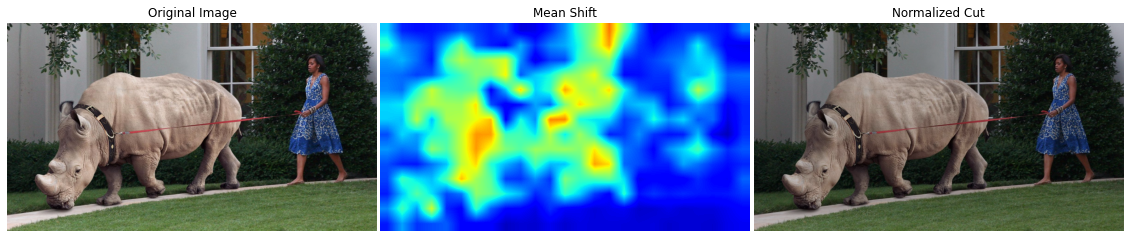

In [11]:
fig, ax = plt.subplots(1,3, figsize=(20,10))
# fig.tight_layout()
fig.subplots_adjust(wspace=0.01)
img = denormalize(passable2img(img)).numpy()
ncut = ncut.repeat(3,axis=-1).reshape(-1, ncut.shape[1],3)

ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(mean_shift, cmap='jet', vmin=0, vmax=1)
ax[1].set_title('Mean Shift')
ax[1].axis('off')

alpha=0.2   # Change this to 0.8 if smaller spliced region
ax[2].imshow((alpha*ncut+(1-alpha)*(1-ncut))*img, vmin=0, vmax=1)
ax[2].set_title('Normalized Cut')
ax[2].axis('off')
plt.show()